# 6. Dimensionality reduction
[*This is part 6 of a 6-part tutorial on machine learning in scikit-learn.*]

Let's recap some of the general techniques we've discussed for building better predictive models:
* Properly validating our models is essential if we want to avoid overfitting and underfitting;
* Increasing dataset size is often the single most effective way to improve performance (when feasible); and,
* Understanding the inductive biases of different regularization methods can help us pick good estimators.

To this toolkit, we now add another broad strategy: using better features. This is, of course, easier said than done. To a large extent, the process of introducing good features—often referred to as *feature engineering*—is a domain-specific enterprise. This makes it hard to describe general methods for engineering good features: if you don't know anything about structural MRI, for example, it may not be at all obvious what kinds of features to extract.

There is, however, one approach to the construction of feature sets that can be approached fairly generically: *dimensionality reduction*. In this section, we'll explore strategies for improving predictions by reducing the size of our feature set in various ways.

As always, we begin with some imports...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge

from support import plot_learning_curves

%matplotlib inline

/srv/conda/envs/notebook/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Let's also read in our data. To save ourselves trouble later, we'll standardize all the brain features and save them in their own DataFrame.

In [2]:
data = pd.read_csv('data/abide2.tsv', sep='\t')

# Store all the freesurfer features in their own DF
X_all = data.filter(like='fs')

# Standardize columns so that regularization has the same effect
X_all = X_all.apply(lambda x: (x - x.mean()) / x.std())

Recall the tension between dataset size and model complexity that's been a recurring theme throughout this tutorial. As we've seen, when we have a limited amount of data, less complex models often outperform more complex ones, because the former are less likely to overfit.

This observation leads directly to another important insight: if we have a feature space that's too big for our model to efficiently learn from, we may be able to reduce the dimensionality of that space until we reach a point that our model is comfortable with. In effect, we're searching for a subspace of our original space that captures most of the reliable variation while shedding most of the noise.

As a toy example, let's look at the first five Freesurfer features in our dataset, which represent extracted surface area measures for 5 different brain regions. When we inspect the data, we observe that three of these variables (`fsArea_L_V1_ROI`, `fsArea_L_V2_ROI`, and `fsArea_L_V3_ROI`) are very strongly correlated:

In [3]:
X_all.iloc[:, :5].corr().round(2)

,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI
fsArea_L_V1_ROI,1.00,0.21,0.57,0.87,0.73
fsArea_L_MST_ROI,0.21,1.00,0.19,0.25,0.26
fsArea_L_V6_ROI,0.57,0.19,1.00,0.64,0.58
fsArea_L_V2_ROI,0.87,0.25,0.64,1.00,0.89
fsArea_L_V3_ROI,0.73,0.26,0.58,0.89,1.00


We can also visualize these relationships in 3 dimensions (we'll take the 3 strongly correlated variables):

interactive(children=(IntSlider(value=10, description='elev', max=90), IntSlider(value=-50, description='azim'…

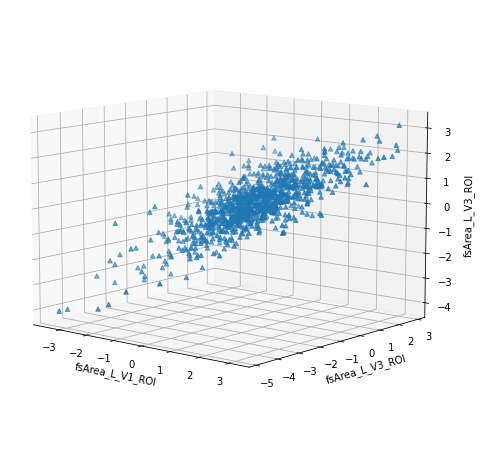

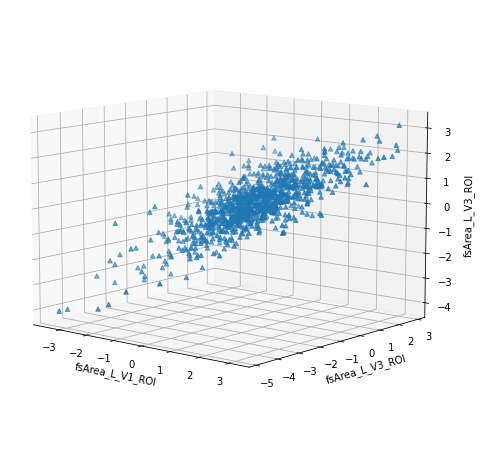

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

f1, f4, f5 = X_all.iloc[:, [0, 3, 4]].values.T
from ipywidgets import interact

def plot_3d_scatter(elev=10, azim=-50):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(f1, f4, f5, s=20, marker='^')
    ax.set(xlabel='fsArea_L_V1_ROI', ylabel='fsArea_L_V3_ROI', zlabel='fsArea_L_V3_ROI')
    ax.view_init(elev, azim);

interact(plot_3d_scatter, elev=(0, 90), azim=(-90, 90));

# if the interactive widget fails, uncomment this for a static version:
plot_3d_scatter();

When two or more features share variance, it's likely (though by no means guaranteed) that they also share predictively useful variance. Consequently, we may be able to reduce the dimensionality of the feature space, or of some subset of the space, without sacrificing much in the way of predictive power.

Broadly speaking, there are two approaches we could take. First, we could simply select a subset of existing features, without any further manipulation. Second, we could combine some or all of our features to create a smaller number of derivative features.


## Feature selection
We've already seen an implicit example of feature selection when we looked at lasso regression. Recall that the L1 penalty imposed by the lasso has the useful property of shrinking coefficients all the way to zero as we increase the penalty parameter.

While feature selection is built into the lasso, this isn't true of most estimators. But we can make feature selection an explicit step in any preprocessing pipeline. As a simple example, we're always free to use our rational judgment about which features to include. In our toy 5-feature example above, for instance, we could reasonably decide to keep `fsArea_4` and discard `fsArea_5`, seeing as the two are very strongly correlated across subjects (r = 0.89), and likely carry little unique information.

In practice, though, rational feature selection doesn't scale very well, and is a fallible strategy even when we have relatively few features. So we usually rely on algorithmic procedures.

To illustrate, let's use the `SelectKBest` transformer in scikit-learn's `feature_selection` module. `SelectKBest` is a rather simple-minded method: it simply retains the <i>k</i> "best" features, as determined by an arbitrary scoring function. In our case, we'll use the `f_regression` selection function, which simply computes a univariate regression. This means that, in practice, all we're doing is taking our 1440 Freesurfer features, correlating each one separately with the target outcome (age), and keeping the *k* features that show the strongest absolute correlation.

We'll also make use of scikit-learn's convenient `Pipeline` class, which allows us to compose a pipeline from an arbitrary sequence of transformers and estimators, and have it behave exactly like a single estimator.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

est = Ridge(100)

pipeline = Pipeline([
    ('feature selection', SelectKBest(f_regression, 30)),
    ('OLS', est),
])

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass k=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


To help us evaluate how much our feature selection step helps improve performance, we'll compare it to randomly-selected sets of 30 and 300 features. (We'll use ridge regression with a relatively high penalty to make sure that the high feature:subject ratio in the latter case doesn't cause catastrophic overfitting.)

In [6]:
X_30 = X_all.sample(30, axis=1)
X_300 = X_all.sample(300, axis=1)

How well can we predict age using these three different sets of 30 predictors?

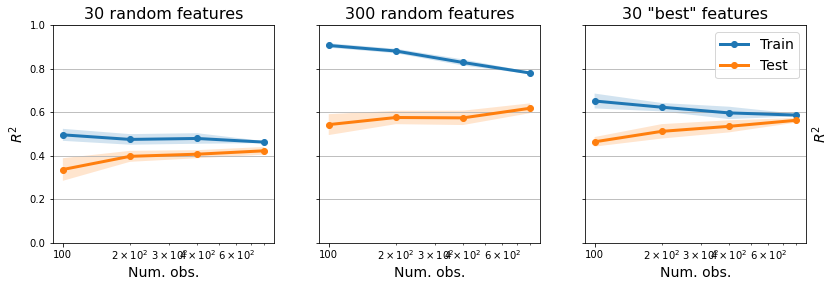

In [7]:
X_sets = [X_30, X_300, X_all]
train_sizes = [100, 200, 400, 800]
labels = ['30 random features', '300 random features', '30 "best" features']
estimators = [est, est, pipeline]

plot_learning_curves(estimators, X_sets, data['age'], train_sizes,
                     labels=labels, cv=5, scoring='r2')

The `SelectKBest` step does indeed improve performance non-trivially beyond what we observe for a random selection of 30 features (compare right and middle panels), and is even competitive with a random set of 300 features, once we have a sufficient number of observations to mitigate overfitting (compare right and left panels for the right-most test observation in each).

## Feature decomposition

Feature selection is helpful when our goal is to reduce the dimensionality of the data without altering the meaning of our features. But if we're not wedded to preserving the same features, we can often do better predictively by *decomposing* our raw variables. The intuition here is that, since every variable reflects some combination of signal and noise, if we can decompose or factorize the signal shared by multiple variables in sensible ways, we should end up with composite features that have a higher signal-to-noise ratio than the raw features we started out with.

This insight is not new, of course; it's exactly what motivates researchers [to sum or average items into scales](https://en.wikipedia.org/wiki/Spearman%E2%80%93Brown_prediction_formula) when using self-report measures. Combining multiple noisy indicators into a single less noisy composite is a powerful dimensionality reduction technique. In a sense, all we're doing here is taking what many scientists have been doing for many decades when using latent variable methods, and situating it specifically in a predictive context.

### Principal Component Analysis (PCA)
By far the most widely used dimensionality reduction technique is principal component analysis (PCA). PCA linearly decomposes a matrix into a set of orthogonal components, where each subsequent component captures as much of the remaining variance in the original matrix as possible. From the standpoint of efficiency (i.e., capturing the maximal amount of variance using the smallest number of components), PCA is optimal: for any fixed number of components <i>k < p</i> (where <i>p</i> is the number of original features), no other linear decomposition method can perform better.

In scikit-learn, using PCA is just as easy as using the other estimators we've encountered. Let's apply it to our toy 3-feature dataset from earlier.

In [8]:
from sklearn.preprocessing import scale

X = X_all.iloc[:, [0, 3, 4]]

In [9]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X);

Notice that when we fit the PCA, we don't pass in any `y` variable! That's because PCA is an unsupervised learning technique. It's not trying to recapture known labels; it simply identifies the axes of principal variation in our data. Let's visualize them:



interactive(children=(IntSlider(value=15, description='elev', max=90, step=5), IntSlider(value=-80, descriptio…

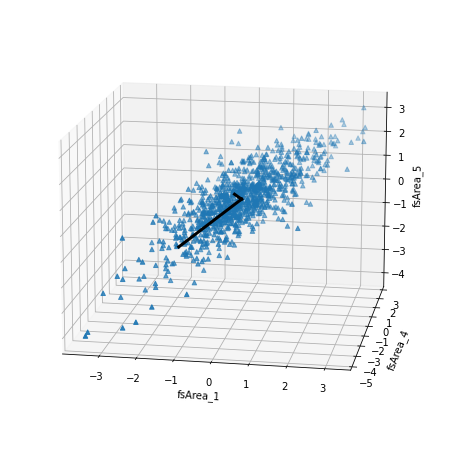

In [10]:
from sklearn.preprocessing import scale

# Assign the three features to separate variables
f1, f4, f5 = scale(X).T

# basically the same function as earlier, except now we plot
# the principal axes in the original space of the data
def plot_3d_scatter(elev=15, azim=-80):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(f1, f4, f5, s=20, marker='^')
    ax.set(xlabel='fsArea_1', ylabel='fsArea_4', zlabel='fsArea_5')
    ax.view_init(elev, azim)
    
    # Add principal axes
    axes = (pca.components_.T * pca.explained_variance_).T
    for pa in axes:
        ax.plot([0, pa[0]], [0, pa[1]], [0, pa[2]], '-k', lw=3, zorder=100)

interact(plot_3d_scatter, elev=(0, 90, 5), azim=(-90, 90, 5));

# uncomment next line if interactive widget fails:
# plot_3d_scatter()

Here we've added the PCA components (black lines) to the plot in the same space. Notice how much more variance the first (longest) component explains than the second and third components.

So much for the toy data. Now let's do something a little more useful and apply PCA to all 1440 Freesurfer features.

In [11]:
# For convenience, sklearn lets us can call fit() and transform() in one step
comps = pca.fit_transform(X_all)

A defining property of PCA is that the $n^{th}$ principal component captures the maximum amount of variance (linearly) possible after accounting for the previous $n-1$ components. In most real-world datasets, where features tend to be at least modestly intercorrelated, this means that the first few components are usually very large relative to the rest. This is almost invariably true of neuroimaging data, because the brain has a good deal of spatial structure—the value you observe at one brain voxel (region, neuron, etc.) will generally tell you something useful about the values of the other units in the local neighborhood. We can observe this in the *scree plot* of the PCA components extracted from our 1,440 Freesurfer features:

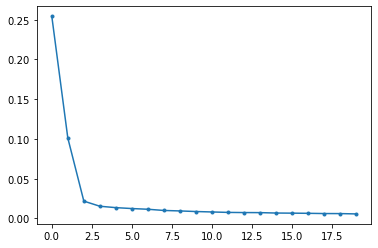

In [12]:
# For visual clarity, we plot only the first 20 components--
# everything past that is close to 0.
plt.plot(pca.explained_variance_ratio_[:20], 'o-', ms=3);

The drop-off past the first few components is dramatic; the first component alone explains over 25% of the variance in the 1440 brain features!

Another useful way to visualize this information is by plotting the cumulative variance explained, which shows us that even with just ~120 features, we're already capturing more than 80% of the variance across all features:

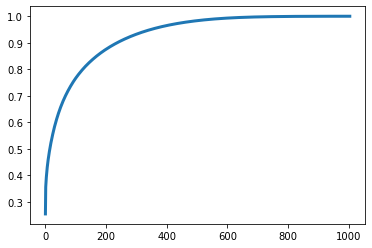

In [13]:
# Cumulative proportion of variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=3);

#### How many components?
A natural question to ask, given a plot like the one above, is: how many components should we retain? Clearly, diminishing returns set in pretty quickly, but exactly where should we draw the line? Should we keep 5 components? 50? 200?

The short of it is that there's no single correct answer to this question. The "right" number of factors depends on one's goals and practical constraints as much as on any quantitative metric. There are plenty of available methods that purport to tell us how many components, factors or clusters we should keep when doing dimensionality reduction, but there's no particular reason to think that any of them have any great insight into the nature of reality (and in most cases, different metrics will give pretty different answers).

It's best to think of this as a purely pragmatic decision: when we opt to keep 7 rather than 70 components, we're not claiming that *there are only 7 important dimensions underlying the data-generating process*; we're simply saying that, given practical constraints, 7 seems like a reasonable number of components to retain. 

Once we accept that dimensionality reduction methods are almost never suitable for use as causal inference tools, it's very natural to replace the question of what the *right* number of dimensions is with the more tractable question of what number is *useful* in a particular situation (and to a particular person). One benefit of adopting a predictive perspective (rather than an inferential one) is that quantifying utility can sometimes be straightforward. In the context of our age prediction model, for example, we could simply say that the "optimal" number of PCA components is the one that maximizes $R^2$ in a suitable validation curve:

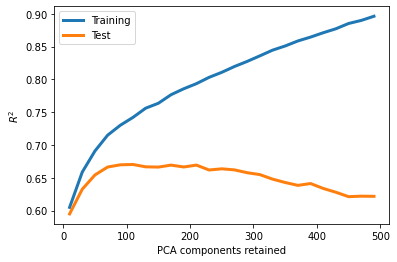

In [14]:
from sklearn.model_selection import validation_curve

pipeline = Pipeline([
    ('PCA', PCA()),
    ('OLS', Ridge(100))
])

n_comps = np.arange(10, 510, 20).astype(int)

train_scores, test_scores = validation_curve(pipeline, X_all, data['age'], 
                                             param_name='PCA__n_components', 
                                             param_range=n_comps, 
                                             cv=5)

plt.plot(n_comps, train_scores.mean(1), lw=3, label='Training')
plt.plot(n_comps, test_scores.mean(1), lw=3, label='Test')
plt.xlabel("PCA components retained")
plt.ylabel("$R^2$")
plt.legend();

In this case, we achieve near-maximal performance even with just 30 - 50 PCA components. After that there's very little change in performance until we get to around 250 components, at which point test performance begins to decline, presumably because there are too many features relative to the number of observations (i.e., the model starts to overfit).

One thing this kind of plot highlights is that the optimal number of PCA components is always data- and estimator-dependent. The bias-variance tradeoff still applies: the larger our dataset, the more we'll benefit from using a high-variance, low-bias estimator (i.e., one that has more flexibility). At a certain point, if our sample is big enough, and we don't mind the extra computation associated with having a large set of predictors, there will be no benefit at all to using a linear dimensionality reduction method like PCA (at least from the standpoint of test error minimization).

As a last step, we can compare age prediction accuracy when using PCA components instead of the raw brain features. The whole motivation for using PCA to dimensionally reduce our feature set was to improve predictive performance, so let's verify that this is in fact what happens...

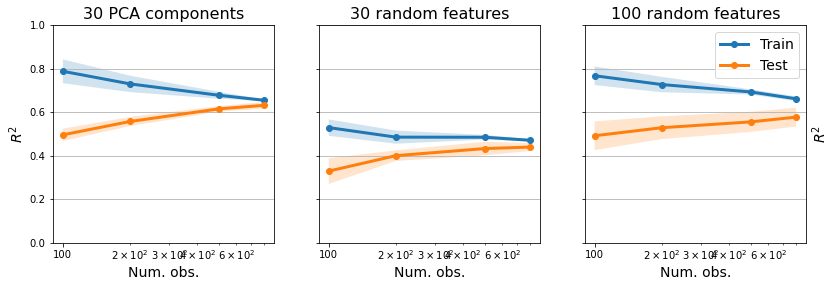

In [15]:
# 30 PCA components
pca_30 = PCA(30).fit_transform(X_all)

# 30 and 100 random features
X_30 = X_all.sample(30, axis=1)
X_100 = X_all.sample(100, axis=1)

X_sets = [pca_30, X_30, X_100]
train_sizes = [100, 200, 500, 800]
labels = ['30 PCA components', '30 random features', '100 random features']
plot_learning_curves(Ridge(100), X_sets, data['age'], train_sizes,
                     labels=labels, cv=5, scoring='r2')

What we see above is a pretty typical pattern of results: for any fixed number of features, PCA components almost always outperform the raw features they were derived from (though this is *not* guaranteed). In this case, the first 30 PCA components derived from the 1440 Freesurfer features explain over 60% of the variance in chronological age—substantially more than the ~50% explained by the 30 random features. In fact, the PCA-based model even does better than a random set of 100 features.

### Other methods
PCA is a dimensionality reduction workhorse, and so long as our goal is strictly to optimize prediction accuracy using linear methods, there's rarely a reason to use anything else. Often, however, predictive accuracy is not the only consideration. For example, in much the same way that we might opt for lasso regression over ridge regression because we value sparsity, we might also want a dimensionality reduction method that produces sparse (and hence seemingly more interpretable) components. Scikit-learn includes implementations of several decomposition approaches (e.g., [sparse PCA](https://en.wikipedia.org/wiki/Sparse_PCA) or [dictionary learning](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html)) that allow us to explictly control the amount of sparsity we introduce. If we value sparsity enough, and the hit to predictive accuracy isn't too big, we might be willing to make the trade.